In [1]:
pip install jax diffrax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.2/193.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.7/177.7 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 5.3 MB/s eta 0:00:00


In [2]:
#version 1, not meant for benchmark but good to visualize process)

import jax
import numpy as np
import jax.numpy as jnp
from jax import random, jit, grad
import diffrax
import lineax as lx
import matplotlib.pyplot as plt

# If H already exists (e.g., loaded from .mat), we'll use it. Else synthesize & normalize.
try:
    H
    print("Using existing H:", H.shape)
except NameError:
    N = 180
    key = random.PRNGKey(0)
    k1, k2, key = random.split(key, 3)
    H = (random.normal(k1, (N, N)) + 1j * random.normal(k2, (N, N))) / jnp.sqrt(2.0)
    row_norm = jnp.sqrt(jnp.mean(jnp.sum(jnp.abs(H) ** 2, axis=1)))
    H = H / row_norm
    print("Made synthetic H:", H.shape)

# Optional: load .mat channel instead of synthesizing
# from scipy.io import loadmat
# mat = loadmat('/path/to/4QAM180H1.mat')['save_H']
# N = mat.shape[0] // 2
# H = mat[:N, :N] + 1j * mat[N:, :N]

@jit
def qpsk_constellation():
    return jnp.array([1+0j, 0+1j, -1+0j, 0-1j], dtype=jnp.complex64)

def qpsk_symbols(N: int, key):
    key, k = random.split(key)
    idx = random.randint(k, (N,), 0, 4)
    const = qpsk_constellation()
    x = const[idx]
    return x, idx, key

# ---------------- Losses (reference style) ----------------
@jit
def loss_datafit(x: jnp.ndarray, y: jnp.ndarray, H: jnp.ndarray) -> jnp.ndarray:
    # Reference uses sum(abs(.)**2) rather than vdot(...).real
    r = H @ x - y
    return jnp.sum(jnp.abs(r) ** 2)

@jit
def loss_const_mod(x: jnp.ndarray) -> jnp.ndarray:
    return jnp.sum((jnp.abs(x) ** 2 - 1.0) ** 2)

# ---------------- Gradients (w.r.t. x*, via JAX) ----------------
# Keep holomorphic=False and apply ONE conjugation in the drift (reference pattern).
dLdx_datafit = jit(grad(loss_datafit, argnums=0, holomorphic=False))
dLdx_const   = jit(grad(loss_const_mod,  argnums=0, holomorphic=False))

@jit
def phase_bias(x: jnp.ndarray, eps: float = 1e-8) -> jnp.ndarray:
    ph = x / (jnp.abs(x) + eps)     # unit phasor
    return ph ** 3                  # later conjugated in the drift

def pack(z):   return jnp.stack([jnp.real(z), jnp.imag(z)], axis=0)  # [2,N]
def unpack(z): return z[0] + 1j * z[1]

# Weights
tau = 2.3   # data-fit
lam = 0.5   # constant-modulus
kap = 0.5   # phase bias

@jit
def drift(t, zpack, args):
    """zpack: [2,N]; args: (H_re, H_im, y_re, y_im)"""
    x = unpack(zpack)
    H_re, H_im, y_re, y_im = args
    Hc = H_re + 1j * H_im
    yc = y_re + 1j * y_im

    # Reference strategy: take JAX grads and conjugate once in the drift
    dx = -tau * dLdx_datafit(x, yc, Hc).conj() \
         -lam * dLdx_const(x).conj() \
         + kap * phase_bias(x).conj()
    return pack(dx)

def make_diffusion(inj_noise_std: float):
    # diagonal diffusion; used only when injecting SDE noise (reference uses VBT)
    def diffusion(t, zpack, args):
        diag = inj_noise_std * jnp.ones_like(zpack)   # [2, N]
        return lx.DiagonalLinearOperator(diag)
    return diffusion

# ------------- SNR helpers (keep "compat" as a toggle) -------------
def sigma_from_snr_db(H: jnp.ndarray, x_true: jnp.ndarray, snr_db: float) -> float:
    y_clean = H @ x_true
    Psig = jnp.mean(jnp.abs(y_clean) ** 2)
    return jnp.sqrt(Psig * 10.0 ** (-snr_db / 10.0))

def noise_std_from_snr_db_compat(snr_db: float, N: int) -> float:
    return jnp.sqrt(2.0 * N * 10.0 ** (-snr_db / 10.0))

def make_y(H, x_true, snr_db, key, compat_noise: bool = True):
    """
    compat_noise=True mimics legacy/reference behavior (re-using one key; non-circular).
    compat_noise=False gives circular CN(0, σ^2).
    """
    key, k1, k2 = random.split(key, 3)
    if compat_noise:
        sigma = noise_std_from_snr_db_compat(snr_db, H.shape[0])
        n = sigma * (random.normal(k1, x_true.shape) + 1j * random.normal(k1, x_true.shape))
    else:
        sigma = sigma_from_snr_db(H, x_true, snr_db)
        n = sigma * (random.normal(k1, x_true.shape) + 1j * random.normal(k2, x_true.shape)) / jnp.sqrt(2.0)
    return H @ x_true + n, key

# ---------------- Integration (reference strategy) ----------------
def run_flow(H, y, key, inj_noise_std=0.0, dt=1e-3, max_steps=2000):
    """
    Reference-like control:
    - If inj_noise_std == 0: ODE, Heun() with PID (adaptive steps).
    - If inj_noise_std > 0: SDE, EulerHeun() + VirtualBrownianTree + constant step.
    """
    N = H.shape[0]
    key, k1, k2 = random.split(key, 3)
    x0 = 0.1 * (random.normal(k1, (N,)) + 1j * random.normal(k2, (N,)))
    z0 = pack(x0)

    args = (jnp.real(H), jnp.imag(H), jnp.real(y), jnp.imag(y))
    t0 = 0.0
    t1 = dt * max_steps if inj_noise_std > 0 else 1.0  # arbitrary horizon for ODE; PID will adapt

    if inj_noise_std > 0:
        # SDE path: constant step, Euler-Heun, VBT noise
        terms = diffrax.MultiTerm(
            diffrax.ODETerm(drift),
            diffrax.ControlTerm(
                make_diffusion(inj_noise_std),
                diffrax.VirtualBrownianTree(t0=t0, t1=t1, tol=1e-3, shape=z0.shape, key=key)
            )
        )
        solver = diffrax.EulerHeun()
        stepper = diffrax.ConstantStepSize()
        dt0 = dt
    else:
        # ODE path: Heun + PID step size controller (reference-style deterministic descent)
        terms = diffrax.ODETerm(drift)
        solver = diffrax.Heun()
        stepper = diffrax.PIDController(rtol=1e-3, atol=1e-6)
        dt0 = None  # not used with PID; diffrax ignores dt0 when controller provided

    save = diffrax.SaveAt(
        steps=True,
        fn=lambda t, z, a: {
            'x': z,
            'loss': loss_datafit(unpack(z), a[2] + 1j * a[3], a[0] + 1j * a[1])
        }
    )

    sol = diffrax.diffeqsolve(
        terms=terms,
        solver=solver,
        t0=t0, t1=t1, dt0=dt if dt0 is None else dt0,
        y0=z0, args=args,
        max_steps=max_steps,
        stepsize_controller=stepper,
        saveat=save,
        throw=False,
        adjoint=diffrax.DirectAdjoint(),
    )
    return sol


Made synthetic H: (180, 180)


In [3]:
#After max steps, collapses to nearest QPSK point
def hard_decide_qpsk(x):
    const = qpsk_constellation()
    d = jnp.abs(const[:, None] - x[None, :])
    return jnp.argmin(d, axis=0)

def plot_constellation_and_traces(H, snr_db=8.0, inj_noise_std=0.0, dt=1e-3, max_steps=2000,
                                  num_traj=12, seed=123, compat_noise=True):
    # 1) build one noisy frame
    key = random.PRNGKey(seed)
    x_true, idx_true, key = qpsk_symbols(H.shape[0], key)
    y, key = make_y(H, x_true, snr_db, key, compat_noise=compat_noise)

    # 2) run flow (ODE if inj_noise_std==0, else SDE)
    sol = run_flow(H, y, key, inj_noise_std=inj_noise_std, dt=dt, max_steps=max_steps)

    # 3) reconstruct trajectory
    steps = int(sol.stats['num_accepted_steps'])
    x_pack = sol.ys['x']                             # (steps, 2, N)
    x_traj = x_pack[:, 0, :] + 1j * x_pack[:, 1, :] # (steps, N)
    xT = x_traj[-1]
    idx_hat = hard_decide_qpsk(xT)

    # ---- Figure A: Constellation trajectories for selected symbols
    const = qpsk_constellation()
    th = jnp.linspace(0, 2*jnp.pi, 512)
    circle = jnp.exp(1j * th)

    # pick K most "mobile" symbols by path length
    path_len = jnp.sum(jnp.abs(jnp.diff(x_traj, axis=0)), axis=0)
    pick = jnp.argsort(-path_len)[:min(num_traj, H.shape[0])]

    plt.figure(figsize=(6.4, 6.4))
    plt.plot(circle.real, circle.imag, lw=1.0, alpha=0.5, label='|z|=1')
    plt.scatter(const.real, const.imag, marker='*', s=140, label='QPSK')
    for i in pick:
        xi = x_traj[:, int(i)]
        plt.plot(xi.real, xi.imag, lw=1.1, alpha=0.9)
        plt.plot([xi.real[0]],  [xi.imag[0]],  'x', ms=6, alpha=0.9)  # start
        plt.plot([xi.real[-1]], [xi.imag[-1]], 'o', ms=5, alpha=0.9)  # end
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim(-1.6, 1.6); plt.ylim(-1.6, 1.6)
    plt.grid(True, ls=':')
    mode = "SDE (EulerHeun,const)" if inj_noise_std > 0 else "ODE (Heun,PID)"
    plt.title(f'Constellation Trajectories — {mode} | inj={inj_noise_std}, SNR={snr_db} dB')
    plt.legend(loc='lower left')
    plt.xlabel('Real'); plt.ylabel('Imag')
    plt.show()

    # ---- Figure B: |x| and angle(x) vs accepted step
    fig, axes = plt.subplots(2, 1, figsize=(7.2, 8.2), sharex=True)
    axes[0].plot(jnp.abs(x_traj))
    axes[0].axhline(1.0, ls='--', lw=1, alpha=0.6, label='|x|=1')
    axes[0].set_ylabel(r'$|x|$'); axes[0].grid(True, ls=':')
    axes[0].legend(loc='lower right')
    axes[0].set_title('Convergence of |x| and angle(x)')

    theta = np.angle(np.asarray(x_traj))          # (steps, N) on CPU for plotting
    theta_u = np.unwrap(theta, axis=0)            # remove 2π discontinuities

    axes[1].plot(theta_u)
    axes[1].set_xlabel('Accepted solver step'); axes[1].set_ylabel('unwrapped angle [rad]')
    axes[1].grid(True, ls=':')
    plt.show()

    SER = float(jnp.mean(idx_true != idx_hat))  # symbol error rate
    print(f"SNR={snr_db:.1f} dB | inj={inj_noise_std:g} | steps={steps} | SER={SER:.4f}")




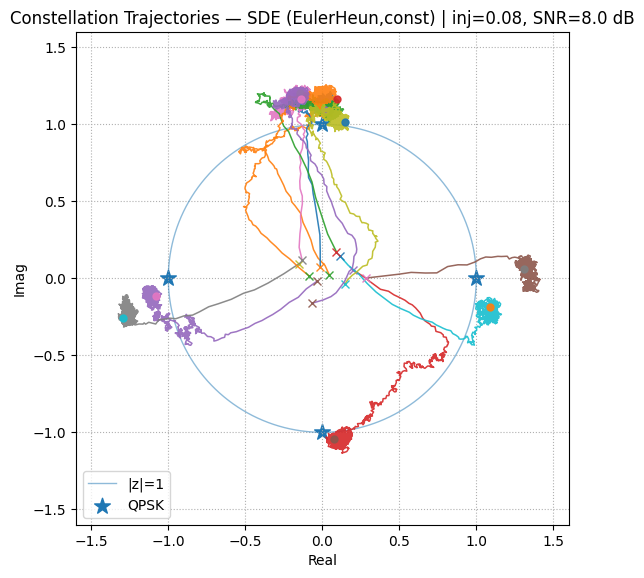

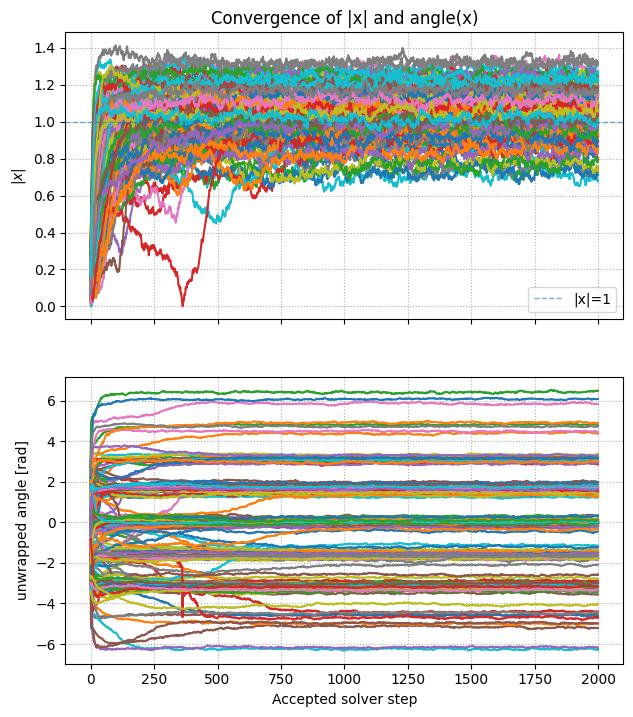

SNR=8.0 dB | inj=0.08 | steps=2000 | SER=0.0444


In [4]:
plot_constellation_and_traces(H, snr_db=8.0, inj_noise_std=0.08,
                              dt=1e-2, max_steps=2000,
                              num_traj=12, seed=6969, compat_noise=False)
